In [1]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

24576/17858 [=========================================] - 0s 1us/step


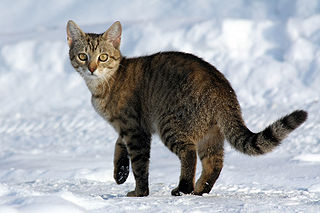

In [2]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [3]:
# Read and decode the image to tensor format.
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

In [4]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

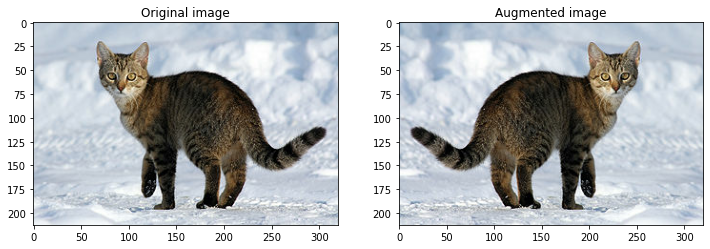

In [5]:
# Flipping the image
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

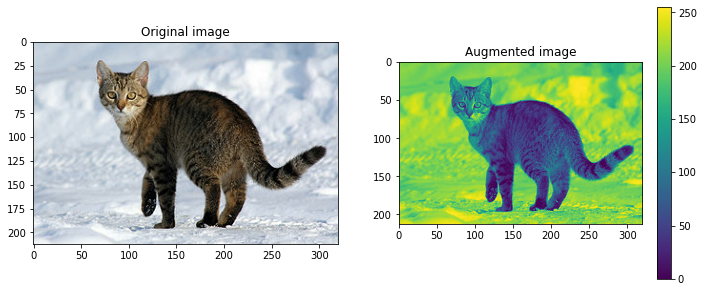

In [6]:
# Grayscale Image
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

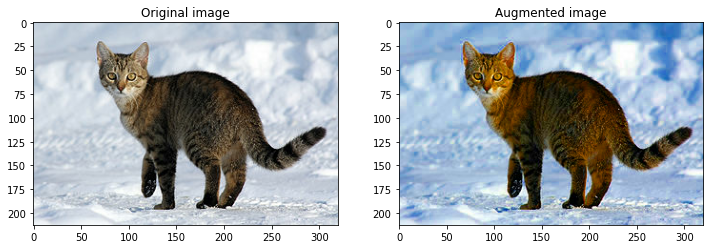

In [7]:
# Saturate the image using saturation factor
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

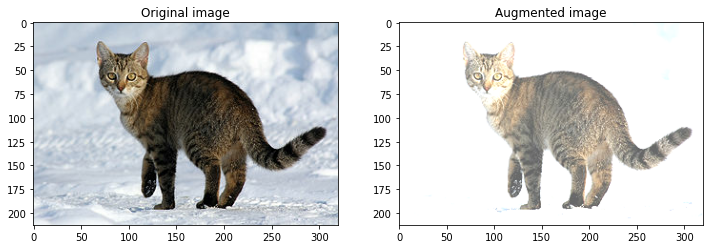

In [8]:
# Change image brightness
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

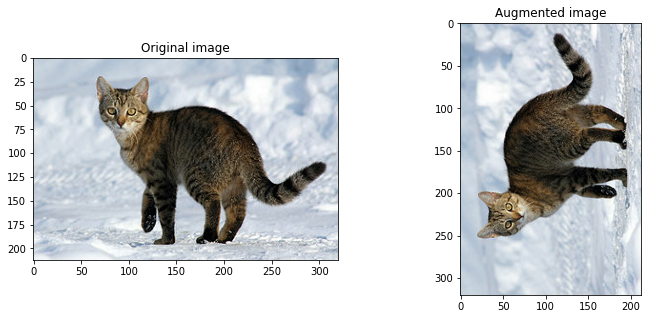

In [9]:
# Rotate the image by 90 degree
rotated = tf.image.rot90(image)
visualize(image, rotated)

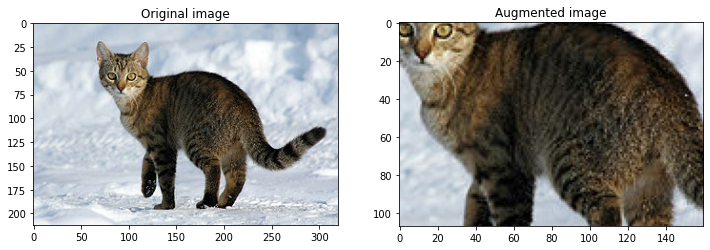

In [10]:
# Crop the image from center
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

## Augment a dataset and train a model with it

In [11]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /Users/jayantparida/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [12]:
# Write a function to augment the images. Map it over the the dataset. 
# This returns a dataset that augments the data on the fly.
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [13]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [14]:
# Create the augmented dataset
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [15]:
# Non-augmented dataset for comparison
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [16]:
# Validation dataset
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

### Create the model

In [17]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

#### Train model without augmentation

In [18]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 18s 556ms/step - loss: 0.8052 - accuracy: 0.7573 - val_loss: 0.3603 - val_accuracy: 0.8963
Epoch 2/50
32/32 [==============================] - 14s 445ms/step - loss: 0.1897 - accuracy: 0.9375 - val_loss: 0.2871 - val_accuracy: 0.9149
Epoch 3/50
32/32 [==============================] - 16s 488ms/step - loss: 0.0725 - accuracy: 0.9805 - val_loss: 0.2793 - val_accuracy: 0.9237
Epoch 4/50
32/32 [==============================] - 17s 528ms/step - loss: 0.0221 - accuracy: 0.9951 - val_loss: 0.2821 - val_accuracy: 0.9309
Epoch 5/50
32/32 [==============================] - 14s 428ms/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 0.3146 - val_accuracy: 0.9288
Epoch 6/50
32/32 [==============================] - 15s 460ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.3577 - val_accuracy: 0.9225
Epoch 7/50
32/32 [==============================] - 15s 469ms/step - loss: 0.0271 - accuracy: 0.9907 - val_loss: 0.3806 - val_accuracy: 0.9174

#### Train model with augmentation

In [19]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 17s 519ms/step - loss: 2.5945 - accuracy: 0.2612 - val_loss: 1.4213 - val_accuracy: 0.6939
Epoch 2/50
32/32 [==============================] - 15s 466ms/step - loss: 1.5176 - accuracy: 0.4824 - val_loss: 0.8506 - val_accuracy: 0.7396
Epoch 3/50
32/32 [==============================] - 18s 572ms/step - loss: 1.0954 - accuracy: 0.6304 - val_loss: 0.5803 - val_accuracy: 0.8000
Epoch 4/50
32/32 [==============================] - 17s 517ms/step - loss: 0.8405 - accuracy: 0.7070 - val_loss: 0.4172 - val_accuracy: 0.8850
Epoch 5/50
32/32 [==============================] - 23s 708ms/step - loss: 0.7027 - accuracy: 0.7646 - val_loss: 0.4126 - val_accuracy: 0.8801
Epoch 6/50
32/32 [==============================] - 24s 753ms/step - loss: 0.6218 - accuracy: 0.8008 - val_loss: 0.3926 - val_accuracy: 0.8649
Epoch 7/50
32/32 [==============================] - 24s 735ms/step - loss: 0.5777 - accuracy: 0.8047 - val_loss: 0.2789 - val_accuracy: 0.9154

In this example the augmented model converges to an accuracy ~95% on validation set. This is slightly higher (+1%) than the model trained without data augmentation.

(0.75, 1.0)

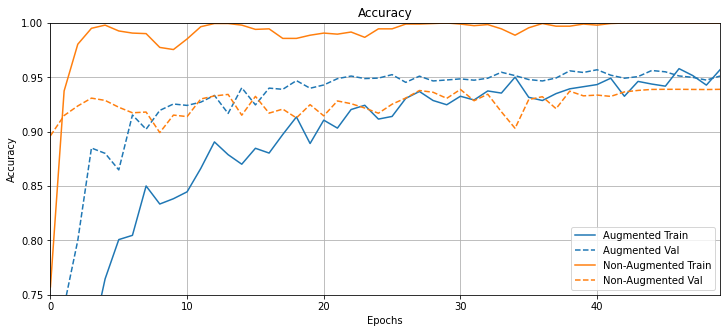

In [20]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])